In [1]:
from IPython.display import display
import numpy as np
import openml
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

def get_openmldata(datset_id):

    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    print(f"Data has {X.shape[0]} rows and {X.shape[1]} columns.")
    display(X.head())
    display(y.head())

    for col in X.columns[categorical_indicator]:
        X[col] = X.loc[:,col].astype("category")
        X[col] = X.loc[:,col].cat.codes.astype("int32")
    
    return X, y, categorical_indicator

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, categorical_features, continuous_features):
        super(TabularDataset, self).__init__()
        self.categorical_features = categorical_features
        self.continuous_features = continuous_features
        self.X_categorical = torch.tensor(X[categorical_features].values, dtype=torch.long)
        self.X_continuous = torch.tensor(X[continuous_features].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X_categorical[idx], self.X_continuous[idx], self.y[idx])

# Zurich delays dataset: https://www.openml.org/search?type=data&sort=runs&id=45045&status=active
# dataset_id = 45045

# Diamonds dataset: https://www.openml.org/search?type=data&sort=runs&id=44059&status=active
dataset_id = 44059

X, y, categorical_indicator = get_openmldata(dataset_id)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .3)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = .7)
n = X.shape[0]
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

print(f"Training on {n_train:,} ({n_train/n:.1%})\nValidation on {n_valid:,} ({n_valid/n:.1%})\nTest on {X_test.shape[0]:,} ({n_test/n:.1%})")

categorical_features = X.columns[np.array(categorical_indicator)]
continuous_features = X.columns[~np.array(categorical_indicator)]

train_dataset =  TabularDataset(X_train, y_train, categorical_features, continuous_features)
valid_dataset =  TabularDataset(X_valid, y_valid, categorical_features, continuous_features)

train_dataloader = DataLoader(train_dataset, batch_size = 1024, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 1024, shuffle=False)

class TabularTransformer(nn.Module):
    def __init__(self, num_continuous_features, num_categories, num_category_embeddings, embedding_dim, num_heads, hidden_dim, dropout_prob):
        super(TabularTransformer, self).__init__()

        # Embedding layers for categorical features
        self.category_embeddings = nn.ModuleList([nn.Embedding(num_categories[i], embedding_dim) for i in range(num_category_embeddings)])
        self.total_embedding_dim = embedding_dim * num_category_embeddings

        # Linear layers for continuous features
        self.continuous_layer = nn.Linear(num_continuous_features, embedding_dim)
        self.total_embedding_dim += embedding_dim
        
        # Transformer layers
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=self.total_embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_prob)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=2)

        # Output layer
        self.output_layer = nn.Linear(self.total_embedding_dim, 1)

    def forward(self, x_categorical, x_continuous):
        # Embed categorical features
        categorical_embeddings = [self.category_embeddings[i](x_categorical[:, i]) for i in range(x_categorical.shape[1])]
        categorical_embeddings = torch.cat(categorical_embeddings, dim=1)

        # Embed continuous features
        continuous_embedding = F.relu(self.continuous_layer(x_continuous))

        # Concatenate embeddings
        x = torch.cat([categorical_embeddings, continuous_embedding], dim=1)

        # Pass through transformer
        x = self.transformer_encoder(x)

        # Pass through output layer
        x = self.output_layer(x)

        return x.squeeze()

Data has 53940 rows and 9 columns.


,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,2,1,3,61.5,55.0,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,4.34,4.35,2.75


0    5.789960
1    5.789960
2    5.793014
3    5.814131
4    5.817111
Name: price, dtype: float64

Training on 37,758 (70.0%)
Validation on 4,854 (9.0%)
Test on 11,328 (21.0%)


In [2]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import time
from joblib import Parallel, delayed
import uuid

def train_one_epoch(model, optimizer, train_dataloader):
    model.train()
    train_loss = 0
    for xb_cat, xb_cont, yb in train_dataloader:
        logits = model(xb_cat, xb_cont)
        loss = F.mse_loss(logits, yb)
        train_loss += loss.item()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return train_loss / len(train_dataloader)

def valid_one_epoch(model, valid_dataloader):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for xb_cat, xb_cont, yb in valid_dataloader:
            logits_valid = model(xb_cat, xb_cont)
            valid_loss += F.mse_loss(logits_valid, yb).item()
    return valid_loss / len(valid_dataloader)

def run_one_param_set(param, max_epochs = 10):
    start = time.time()
    learning_rate =  param["learning_rate"]
    embedding_dim = param["embedding_dim"]
    hidden_dim = param["hidden_dim"]
    num_heads = param["num_heads"]
    num_layers = param["num_layers"]
    dropout_prob = param["dropout_prob"]
    if embedding_dim % num_heads != 0:
        print(f"Warning: embedding_dim {embedding_dim} must be divisible by num_heads {num_heads}.")
        embedding_dim = 100 * num_heads
        print(f"Changing embedding_dim to {embedding_dim}")

    model = TabularTransformer(num_continuous_features, num_categories, num_category_embeddings, embedding_dim, num_heads, hidden_dim, dropout_prob)
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
    experiment_id = uuid.uuid1().hex
    
    train_losses = []
    valid_losses = []
    for epoch in range(max_epochs):
        train_loss = train_one_epoch(model, optimizer, train_dataloader)
        valid_loss = valid_one_epoch(model, valid_dataloader)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    report_dict = {}
    report_dict["id"] = experiment_id
    report_dict["train_loss"] = train_loss
    report_dict["valid_loss"] = valid_loss
    report_dict["n_epochs"] = max_epochs
    report_dict["time"] = (time.time() - start)/60
    report_dict["n_parameters"] = sum(p.numel() for p in model.parameters())
    report_dict.update(param)
    epoch_data = {"id": experiment_id, "train_losses": train_losses, "valid_losses": valid_losses}
    return report_dict, epoch_data

param_grid = dict(
    learning_rate = loguniform(0.001, 0.1),
    embedding_dim = [100, 200, 300, 400],   # output dimensions for data inputs
    hidden_dim = [100, 200, 300, 400],      # feedforward dimension within the transformer
    num_heads = [1, 2, 3, 4, 5],            # number of attention heads
    num_layers = [2, 4, 6],                 # number of transformer layers
    dropout_prob = [0.2, .3, .4, .5],       # dropout probability
    )

num_continuous_features = len(continuous_features)
num_categories = [len(set(X[col])) for col in categorical_features]
num_category_embeddings = len(categorical_features)

sampler = ParameterSampler(param_grid, n_iter=10)
hpo_results = Parallel(n_jobs=-1)(delayed(run_one_param_set)(param, 100) for param in sampler)

Changing embedding_dim to 300
Changing embedding_dim to 300
Changing embedding_dim to 300


In [3]:
def display_metrics(report_dicts):
    table = pd.concat([pd.DataFrame(rd, index=[i]) for i, rd in enumerate(report_dicts)])
    return table

hpo_summary = [res[0] for res in hpo_results]
hpo_epochs = [res[1] for res in hpo_results]

df_summary = display_metrics(hpo_summary)
df_summary

,id,train_loss,valid_loss,n_epochs,time,n_parameters,dropout_prob,embedding_dim,hidden_dim,learning_rate,num_heads,num_layers
0,557fa954db0811ed992cdef1ad651a9c,1.054822,2.024117,100,64.722818,18762301,0.2,300,200,0.005888,1,2
1,557f8d20db0811edbc45def1ad651a9c,1.061653,2.941930,100,79.264872,32696201,0.3,400,200,0.019054,4,4
2,55858ce8db0811eda74ddef1ad651a9c,1.048315,9.377318,100,80.823213,34616801,0.5,400,400,0.005752,4,2
3,557b7ffadb0811edaa2adef1ad651a9c,1.055532,6.098310,100,68.034304,19482601,0.4,100,300,0.003646,3,6
4,55814e8adb0811edadb0def1ad651a9c,1.045475,4.252576,100,69.369671,20202901,0.4,400,400,0.001713,3,2
5,557fca06db0811ed9a69def1ad651a9c,1.040321,1.559156,100,24.159588,2174201,0.2,100,100,0.009573,5,2
6,557ddd54db0811edb0dddef1ad651a9c,1.050659,1.938899,100,69.127872,20202901,0.5,200,400,0.047112,3,4
7,558797e0db0811ed9bd6def1ad651a9c,1.049715,5.534326,100,80.428262,32696201,0.5,400,200,0.007522,5,4
8,557a6ed0db0811ed84c2def1ad651a9c,1.041221,1.116427,100,20.246026,2414501,0.2,100,200,0.002316,2,4
9,55925bd0db0811ed9849def1ad651a9c,1.045887,5.797931,100,81.036829,33656501,0.4,400,300,0.006361,5,4


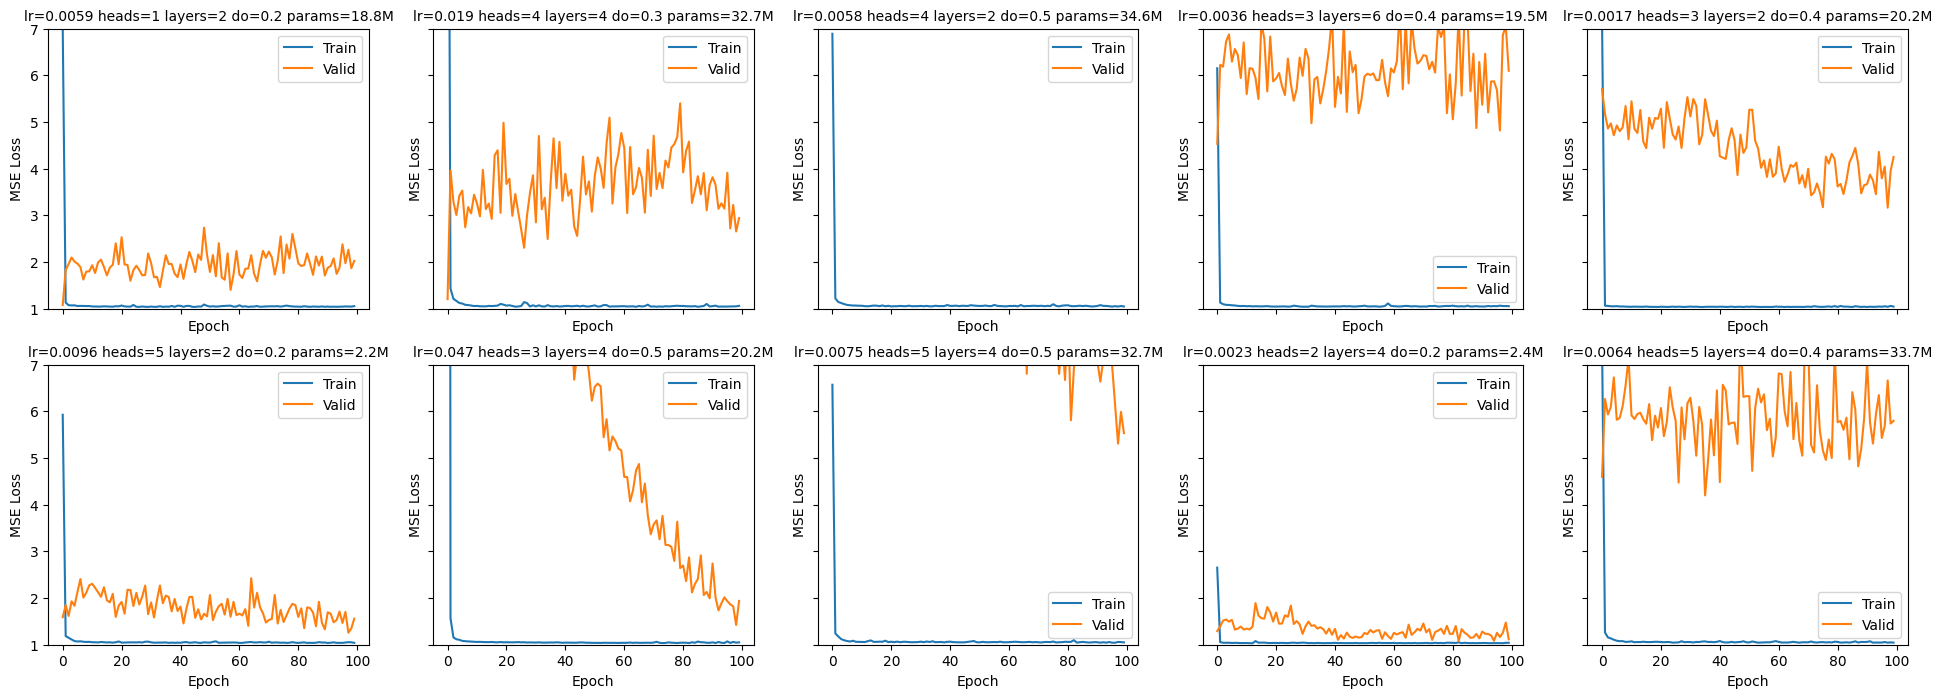

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = "medium"

n_cols = 5
n_rows = 2

fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, figsize=(24,8))

row_num = 0
col_num = 0
for exp_idx in range(df_summary.shape[0]):
    
    # Create chart
    ax = axs[row_num, col_num]
    n_epochs = len(hpo_epochs[exp_idx]["train_losses"])
    ax.plot(range(n_epochs), hpo_epochs[exp_idx]["train_losses"], color = "tab:blue", label = "Train")
    ax.plot(range(n_epochs), hpo_epochs[exp_idx]["valid_losses"], color = "tab:orange", label = "Valid")
    ax.set_ylabel("MSE Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylim(1, 7)
    ax.legend()

    # Create title
    experiment_id = hpo_epochs[exp_idx]["id"]
    params = df_summary[df_summary["id"] == experiment_id]
    lr = params["learning_rate"].iloc[0]
    heads = params["num_heads"].iloc[0]
    layers = params["num_layers"].iloc[0]
    do = params["dropout_prob"].iloc[0]
    n_params = params["n_parameters"].iloc[0]
    ax.set_title(f"{lr=:.2} {heads=} {layers=} {do=:.1f} params={n_params/1e6:.1f}M")
    if col_num == (n_cols - 1):
        col_num = 0
        row_num += 1
    else:
        col_num += 1